In [1]:
#!pip install xarray-spatial
#!pip install pyarrow
import os
import pandas as pd
import pathlib
import xarray as xr
import pyarrow
import earthaccess
#!pip install dask
import xrspatial
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import geopandas as gpd
import glob
import rioxarray as rxr
import rioxarray.merge as rxrmerge
from shapely.geometry import box
import matplotlib.pyplot as plt


import rasterio
from rasterio.mask import mask
import zipfile

In [2]:
data_dir = os.path.join(
    pathlib.Path.home(),

    'habitat-suitability-sarawirth',
    'data'
)
os.makedirs(data_dir, exist_ok=True)

# Load state parks shapefile into a GeoDataFrame
site_dir = os.path.join(data_dir, 'PADUS4_0_State_CA_GDB')
os.makedirs(site_dir, exist_ok = True)

pa_path = os.path.join(site_dir, "PADUS4_0_StateCA.gdb")

pa_shp = gpd.read_file(pa_path)
pa_shp = pa_shp.to_crs(epsg = "4326")
pa_shp['geometry'].apply(lambda geom: geom.make_valid() if not isinstance(geom, MultiPolygon)and not geom.is_valid else geom)
pa_shp = pa_shp[pa_shp.geometry.is_valid]
pa_shp = pa_shp.dropna(subset = ['geometry'])
pa_shp = pa_shp[['Own_Name', 'Mang_Name', 'Unit_Nm', 'Loc_Nm', 'geometry']]



/Users/sarawirth/miniconda3/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'PADUS4_0_StateCA.gdb': 'PADUS4_0Fee_State_CA' (default), 'PADUS4_0Designation_State_CA', 'PADUS4_0Easement_State_CA', 'PADUS4_0Proclamation_State_CA', 'PADUS4_0Comb_DOD_Trib_NGP_Fee_Desig_Ease_State_CA', 'PADUS4_0Marine', 'Public_Access', 'Agency_Name', 'Agency_Type', 'Category', 'Designation_Type', 'GAP_Status', 'IUCN_Category', 'State_Name'. Specify layer parameter to avoid this warning.
  result = read_func(
/Users/sarawirth/miniconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [3]:
# Filter for the two state parks

rrcsp_gdf = pa_shp[pa_shp["Loc_Nm"] == "Red Rock Canyon State Park"]
rrcsp_gdf = rrcsp_gdf[['Loc_Nm', 'geometry']]


#mdlt_gdf = pa_shp[pa_shp["Loc_Nm"] == "Mojave Desert Land Trust"]
#mdlt_gdf = mdlt_gdf[['Loc_Nm', 'geometry']]


ripley_sp_gdf = pa_shp[pa_shp["Loc_Nm"] == "Arthur B. Ripley Desert Woodland State Park"]
ripley_sp_gdf = ripley_sp_gdf[["Loc_Nm", "geometry"]]


In [4]:
# Combine the two parks into a single GeoDataFrame
top2sites_gdf = gpd.GeoDataFrame(pd.concat([rrcsp_gdf,ripley_sp_gdf], ignore_index= True))


<Axes: >

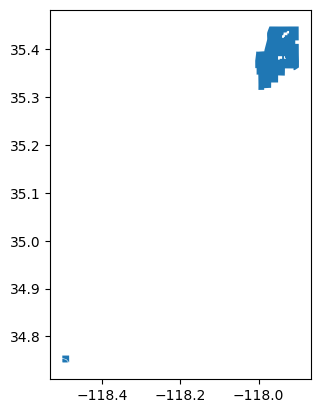

In [5]:
top2sites_gdf.plot()

In [6]:
earthaccess.login()

In [7]:
datasets =earthaccess.search_datasets(keyword='SRTM DEM')


In [8]:
for dataset in datasets:
    print(dataset['umm']['ShortName'], dataset['umm'],['EntryTitle'])
    break


NASADEM_SHHP {'CollectionCitations': [{'Title': 'NASA SRTM-only Height and Height Precision Global 1 arc second V001', 'Creator': 'Sean Buckley', 'ReleaseDate': '2020-02-13T00:00:00.000Z', 'ReleasePlace': 'Sioux Falls, South Dakota, USA', 'Publisher': 'NASA EOSDIS Land Processes Distributed Active Archive Center', 'OnlineResource': {'Name': 'DOI Landing Page', 'Linkage': 'https://doi.org/10.5067/MEaSUREs/NASADEM/NASADEM_SHHP.001'}}], 'AdditionalAttributes': [{'Value': '10.5067/MEaSUREs/NASADEM/NASADEM_SHHP.001', 'Name': 'identifier_product_doi', 'Description': 'Digital object identifier that uniquely identifies this data product', 'DataType': 'STRING'}, {'Value': 'https://doi.org', 'Name': 'identifier_product_doi_authority', 'Description': 'URL of the digital object identifier resolving authority', 'DataType': 'STRING'}], 'SpatialExtent': {'SpatialCoverageType': 'HORIZONTAL', 'HorizontalSpatialDomain': {'Geometry': {'CoordinateSystem': 'CARTESIAN', 'BoundingRectangles': [{'NorthBoundin

In [9]:
srtm_data_dir = os.path.join(
    pathlib.Path.home(),

    'habitat-suitability-sarawirth',
    'data',
    'srtm_data'
)



srtm_pattern = os.path.join(srtm_data_dir, '*.hgt.zip')
#bounds_rrcsp = tuple(rrcsp_gdf.total_bounds)
bounds_ripley = tuple(ripley_sp_gdf.total_bounds)

if not glob.glob(srtm_pattern):
    
    '''srtm_results_rrcsp = earthaccess.search_data(
        short_name = 'SRTMGL1',
        bounding_box = bounds_rrcsp
    )
    earthaccess.download(srtm_results_rrcsp, srtm_data_dir)
    '''
    
    srtm_results_ripley = earthaccess.search_data(
        short_name = 'SRTMGL1',
        bounding_box = bounds_ripley
    )
    earthaccess.download(srtm_results_ripley, srtm_data_dir)


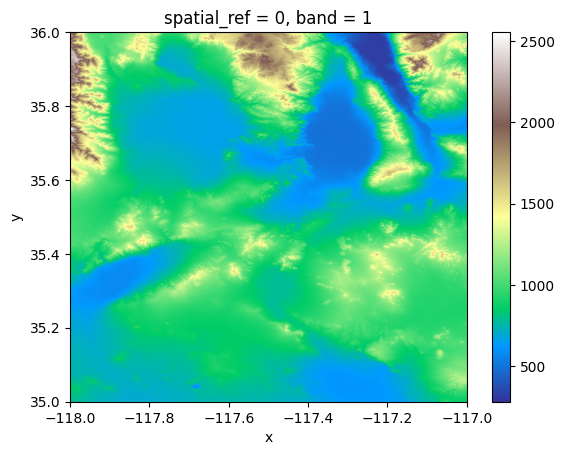

In [10]:

srtm_da_list = []
file = glob.glob(srtm_pattern)[0]
tile_da = rxr.open_rasterio(file,mask_and_scale = True).squeeze()
srtm_da_list.append(tile_da)
srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap = 'terrain')

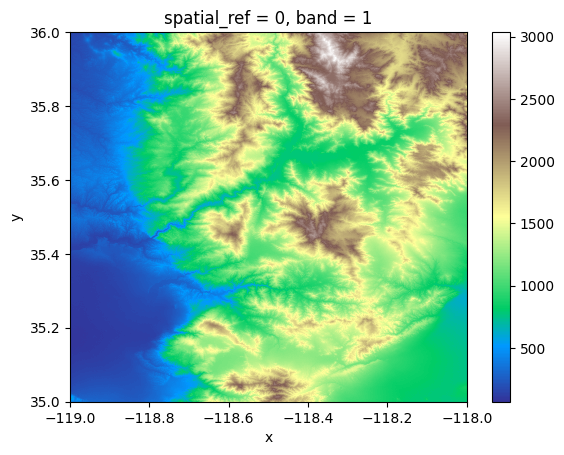

In [11]:
srtm_da_list = []
file = glob.glob(srtm_pattern)[1]
tile_da = rxr.open_rasterio(file,mask_and_scale = True).squeeze()
srtm_da_list.append(tile_da)
srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap = 'terrain')

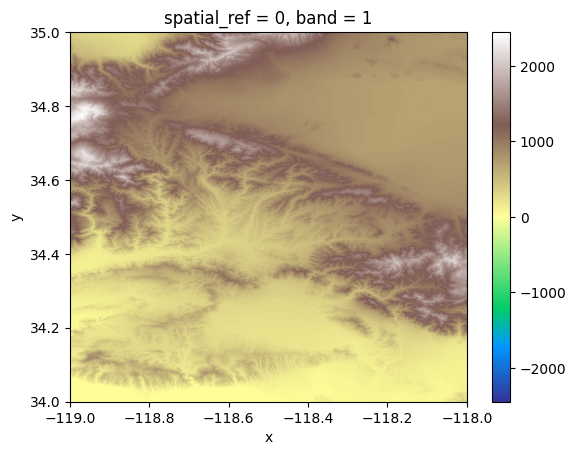

In [12]:
srtm_da_list = []
file = glob.glob(srtm_pattern)[2]
tile_da = rxr.open_rasterio(file,mask_and_scale = True).squeeze()
srtm_da_list.append(tile_da)
srtm_da = rxrmerge.merge_arrays(srtm_da_list)
srtm_da.plot(cmap = 'terrain')

#import matplotlib.pyplot as plt
#plt.title("pH (15–30 cm Depth)")
#plt.xlabel("Longitude")
#plt.ylabel("Latitude")
#plt.show()

[<xarray.DataArray (y: 3601, x: 3601)> Size: 52MB
[12967201 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -118.0 -118.0 -118.0 ... -117.0 -117.0 -117.0
  * y            (y) float64 29kB 36.0 36.0 36.0 36.0 ... 35.0 35.0 35.0 35.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    units:          m, <xarray.DataArray (y: 3601, x: 3601)> Size: 52MB
[12967201 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -119.0 -119.0 -119.0 ... -118.0 -118.0 -118.0
  * y            (y) float64 29kB 36.0 36.0 36.0 36.0 ... 35.0 35.0 35.0 35.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    units:          m, <xarray.DataArray (y: 3601, x: 3601)> Size: 52MB
[12967201 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -119.0 -119.0 -119.0 ... -118.0 -118.0 -118.0
  * y            (y) float64 29kB 35.0 35.0 

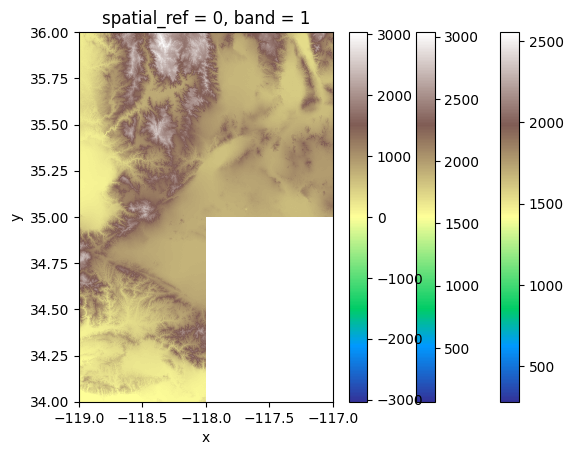

In [13]:
srtm_da_list = []
for srtm_path in glob.glob(srtm_pattern):
    tile_da = rxr.open_rasterio(srtm_path, mask_and_scale = True).squeeze()
    #cropped_da = tile_da.rio.clip_box(bounds_ripley)
    srtm_da_list.append(tile_da)
    
    srtm_da =rxrmerge.merge_arrays(srtm_da_list)
    
    srtm_da.plot(cmap = 'terrain')
print(srtm_da_list)

In [14]:
# Check the CRS of the raster data
print(srtm_da.rio.crs)


EPSG:4326


<Axes: >

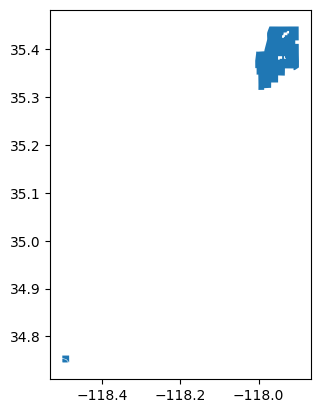

In [15]:
top2sites_gdf = top2sites_gdf.to_crs(srtm_da.rio.crs)
top2sites_gdf.plot()

In [16]:
srtm_da

<xarray.DataArray (y: 7201, x: 7201)> Size: 207MB
array([[ 161.,  160.,  159., ..., 1240., 1238., 1236.],
       [ 162.,  161.,  160., ..., 1237., 1235., 1232.],
       [ 161.,  161.,  160., ..., 1233., 1231., 1228.],
       ...,
       [   0.,    0.,    0., ...,   nan,   nan,   nan],
       [   0.,    0.,    0., ...,   nan,   nan,   nan],
       [   0.,    0.,    0., ...,   nan,   nan,   nan]], dtype=float32)
Coordinates:
  * x            (x) float64 58kB -119.0 -119.0 -119.0 ... -117.0 -117.0 -117.0
  * y            (y) float64 58kB 36.0 36.0 36.0 36.0 ... 34.0 34.0 34.0 34.0
    spatial_ref  int64 8B 0
    band         int64 8B 1
Attributes:
    AREA_OR_POINT:  Area

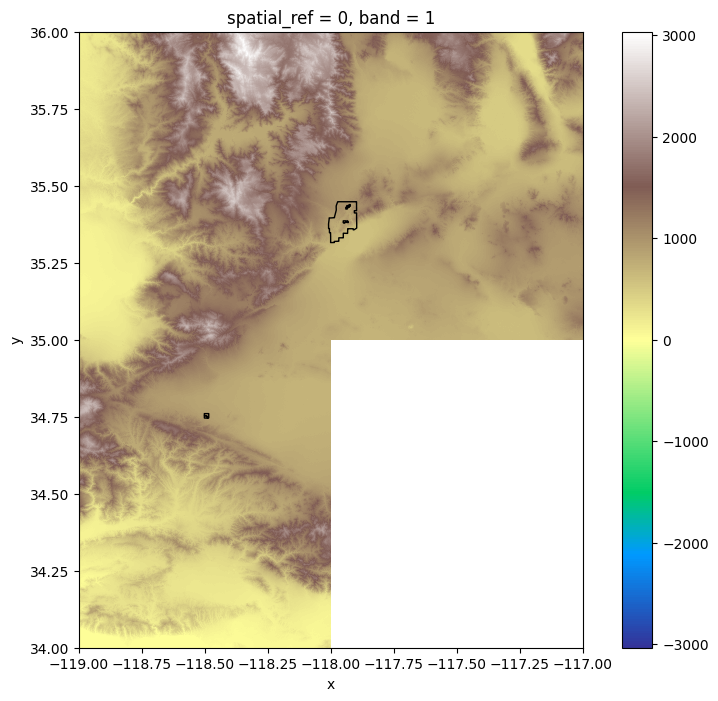

In [17]:


# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the raster data (elevation)
srtm_da.plot(ax=ax, cmap='terrain')

# Plot the state park area (GeoDataFrame) on top
top2sites_gdf.plot(ax=plt.gca(), color='none', edgecolor='black')

plt.show()


In [18]:
import geopandas as gpd

# Ensure original CRS is correctly set
if top2sites_gdf.crs is None:
    top2sites_gdf.set_crs("EPSG:4326", inplace=True)  # Define original CRS

# Reproject to match SRTM (EPSG:32611)
top2sites_utm = top2sites_gdf.to_crs("EPSG:32611")

# Confirm the CRS change
print("Reprojected Top 2 Sites CRS:", top2sites_utm.crs)

Reprojected Top 2 Sites CRS: EPSG:32611


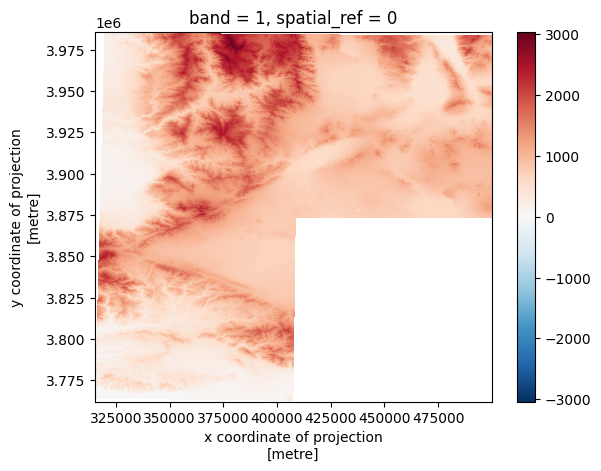

In [19]:
srtm_proj_da = srtm_da.rio.reproject(32611)#reproject into a coordinate system that uses meters
srtm_proj_da.plot()

In [20]:
print(f"SRTM CRS: {srtm_proj_da.rio.crs}")
print(f"State Park CRS: {top2sites_utm.crs}")

SRTM CRS: EPSG:32611
State Park CRS: EPSG:32611


In [21]:

#state_parks_utm = top2sites_gdf.to_crs(srtm_proj_da.rio.crs)

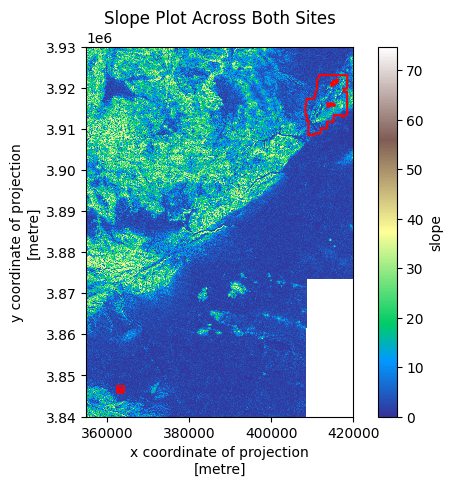

In [68]:
import matplotlib.pyplot as plt
slope_da = xrspatial.slope(srtm_proj_da)
slope_da.plot(cmap = 'terrain')
top2sites_gdf.to_crs(32611).boundary.plot(ax = plt.gca(), color = 'red')
plt.xlim(355000, 420000)
plt.ylim(3840000, 3930000)


plt.title("Slope Plot Across Both Sites")
plt.show()


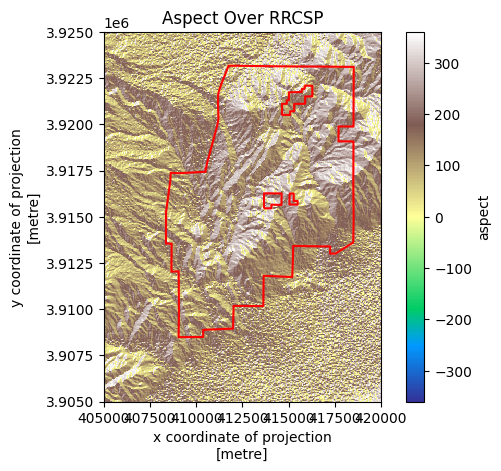

In [69]:
aspect_da = xrspatial.aspect(srtm_proj_da)

# Plot the aspect with the terrain colormap
aspect_da.plot(cmap='terrain')

# Plot the boundaries of your sites
top2sites_gdf.to_crs(32611).boundary.plot(ax=plt.gca(), color='red')

# Set the axis limits to zoom in
plt.xlim(405000, 420000)
plt.ylim(3905000, 3925000)

plt.title("Aspect Over RRCSP")
plt.show()

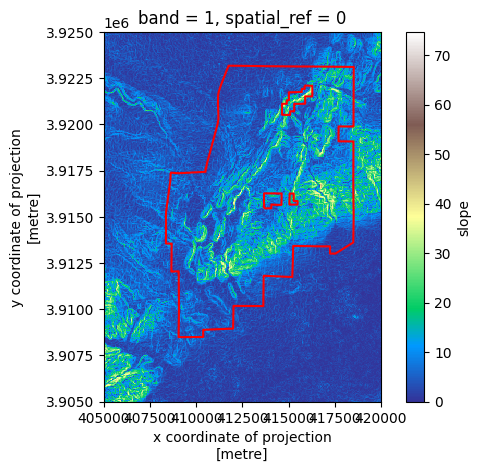

In [24]:
slope_da = xrspatial.slope(srtm_proj_da)
slope_da.plot(cmap = 'terrain')
top2sites_gdf.to_crs(32611).boundary.plot(ax = plt.gca(), color = 'red')
plt.xlim(405000, 420000)
plt.ylim(3905000, 3925000)


plt.show()

In [ ]:
####Download climate model data######

In [25]:
import rioxarray as rxr
import xarray as xr
import netCDF4

import os
import pathlib

Climate Models: 

RRCSP
1) Warm and dry: HadGEM2-CC365: 102.7F, 3.1 in
2) Cold and dry: NORESM1-M: 101.3 F, 3 in
3) Warm and wet: CanESM2: 103.4 F, 6.3 in
4) Cold and wet: MRI-CGCM3: 99.9 F, 5.6 in

Arthur B Ripley State Park
1) Warm and wet: CanESM2: 96.8 F, 14.5 in
2) Warm and dry: HadGEM2-CC365: 95.8F, 7.6 in
3) Cold and dry: NORESM1-M: 94.1 F, 6.7 in
4) Cold and wet: MRI-CGCM3: 93.1 F, 13.6 in

In [27]:
!pip install netCDF4

In [28]:
import xarray as xr
import pandas as pd

In [58]:
top2sites_gdf

,Loc_Nm,geometry
0,Red Rock Canyon State Park,"MULTIPOLYGON (((-117.89779 35.44443, -117.8977..."
1,Arthur B. Ripley Desert Woodland State Park,"MULTIPOLYGON (((-118.48915 34.74617, -118.4892..."


In [66]:
'''Warm and dry: HadGEM2-CC365: 102.7F, 3.1 in
Cold and dry: NORESM1-M: 101.3 F, 3 in
Warm and wet: CanESM2: 103.4 F, 6.3 in
Cold and wet: MRI-CGCM3: 99.9 F, 5.6 in
'''
import pandas as pd
def convert_longitude(longitude):

    return (longitude -360) if longitude >180 else longitude
    # Open the dataset with no time decoding
maca_da_list = []   
#sites = ["rrcsp", "ripley"]
models = ["HadGEM2-CC365", "NorESM1-M", "CanESM2", "MRI-CGCM3"]
variables = ['pr']
#scenarios = ["historical", "rcp45"]
for idx, row in top2sites_gdf.iterrows():
    site_name = row['Loc_Nm']  # or whatever column contains the site name
    site_geom = gpd.GeoDataFrame([row], crs=top2sites_gdf.crs)  # single-row GeoDataFrame
    
    for model in models:
        for variable in variables:
            for start_year in [2091,2006]:
                end_year = start_year + 4
                maca_url = (
                    f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/{model}'
                    f'/macav2metdata_{variable}_{model}_r1i1p1_rcp45_'
                    f'{start_year}_{end_year}_CONUS_monthly.nc'
                )
                maca_da = xr.open_dataset(maca_url, engine='netcdf4', decode_times=False).squeeze().precipitation
                bounds = site_gdf.to_crs(maca_da.rio.crs).total_bounds
                maca_da = maca_da.assign_coords(
                    lon = ("lon",
                           [convert_longitude(l) for l in maca_da.lon.values]))
                
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon',y_dim='lat')
                maca_da.rio.clip_box(*bounds)
                maca_da_list.append(dict(
                    site_name= site_name,
                    variable = variable,
                    start_year=start_year,
                    model = model,
                    da=maca_da))
maca_df = pd.DataFrame(maca_da_list)
maca_df[['site_name','model','variable','start_year']]

Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1
Note:Caching=1


,site_name,model,variable,start_year
0,Red Rock Canyon State Park,HadGEM2-CC365,pr,2091
1,Red Rock Canyon State Park,HadGEM2-CC365,pr,2006
2,Red Rock Canyon State Park,NorESM1-M,pr,2091
3,Red Rock Canyon State Park,NorESM1-M,pr,2006
4,Red Rock Canyon State Park,CanESM2,pr,2091
5,Red Rock Canyon State Park,CanESM2,pr,2006
6,Red Rock Canyon State Park,MRI-CGCM3,pr,2091
7,Red Rock Canyon State Park,MRI-CGCM3,pr,2006
8,Arthur B. Ripley Desert Woodland State Park,HadGEM2-CC365,pr,2091
9,Arthur B. Ripley Desert Woodland State Park,HadGEM2-CC365,pr,2006


array([-118.501842  ,   34.745549  , -117.89704865,   35.44811227])

<xarray.DataArray 'precipitation' (time: 48, lat: 18, lon: 16)> Size: 55kB
[13824 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 144B 34.73 34.77 34.81 34.85 ... 35.35 35.4 35.44
  * time     (time) float32 192B 7.155e+04 7.158e+04 ... 7.295e+04 7.298e+04
  * lon      (lon) float64 128B -118.5 -118.5 -118.4 ... -118.0 -117.9 -117.9
    crs      int64 8B 0
Attributes:
    long_name:      Monthly Precipitation Amount
    units:          mm
    standard_name:  precipitation
    cell_methods:   time: sum(interval: 24 hours): sum over days
    comments:       Total monthly precipitation at surface: includes both liq...
    _ChunkSizes:    [  8 115 276]

In [ ]:
#Now its clipped to 18x16

In [ ]:


# Check the time variable and its attributes
print(raw_ds['time'])

# Extract the time variable (which may be in "days since" format or a string)
time_values = raw_ds['time'].values

# Access the time units from the 'time' variable's attributes
time_units = raw_ds['time'].attrs['units']

# Convert time to pandas datetime manually
time_values = pd.to_datetime(time_values, unit='D', origin=pd.to_datetime(time_units.split(' since ')[-1]))

# Assign the converted datetime to the 'time' coordinate
raw_ds['time'] = ('time', time_values)

# Now you can proceed to use the dataset
maca_ds = raw_ds

# Check the dataset after the time conversion
print(maca_ds)
